<a href="https://colab.research.google.com/github/MarioSigal/Aprendizaje-Automatico-I-y-II/blob/main/AAG/TP_AAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TP: Clasificación de nodos con Graph Neural Network

In [2]:
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00


In [13]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

Cora es un grafo de citas entre artículos científicos donde:

* **Cada nodo** = un paper.

* **Cada arista** = una cita entre dos papers.

* **Cada nodo tiene features** = un vector binario indicando qué palabras del vocabulario aparecen en ese paper.

* **Cada nodo tiene una etiqueta** = la categoría temática del paper (Machine Learning, NLP, IR, etc.).

Entrenando con un subconjunto de estos nodos, quiero predecir las etiquetas en su complemento.

In [4]:
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

print(data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


Defino una GNN estandar  (una Graph Convolutional Network de dos capas)

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # 1° message passing + activación
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # 2° message passing → logits finales
        x = self.conv2(x, edge_index)
        return x

model = GCN(
    in_channels=dataset.num_node_features,
    hidden_channels=16,
    out_channels=dataset.num_classes
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


Entrenamiento:

In [6]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs.append(acc)
    return accs

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.3f} | "
              f"Train: {train_acc:.3f} | Val: {val_acc:.3f} | Test: {test_acc:.3f}")


/tmp/ipython-input-107071179.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(loss)


Epoch 020 | Loss: 0.275 | Train: 1.000 | Val: 0.768 | Test: 0.804
Epoch 040 | Loss: 0.069 | Train: 1.000 | Val: 0.782 | Test: 0.798
Epoch 060 | Loss: 0.051 | Train: 1.000 | Val: 0.768 | Test: 0.788
Epoch 080 | Loss: 0.046 | Train: 1.000 | Val: 0.766 | Test: 0.798
Epoch 100 | Loss: 0.040 | Train: 1.000 | Val: 0.766 | Test: 0.793
Epoch 120 | Loss: 0.041 | Train: 1.000 | Val: 0.772 | Test: 0.795
Epoch 140 | Loss: 0.066 | Train: 1.000 | Val: 0.772 | Test: 0.794
Epoch 160 | Loss: 0.041 | Train: 1.000 | Val: 0.776 | Test: 0.804
Epoch 180 | Loss: 0.031 | Train: 1.000 | Val: 0.772 | Test: 0.798
Epoch 200 | Loss: 0.028 | Train: 1.000 | Val: 0.764 | Test: 0.801


Visualización

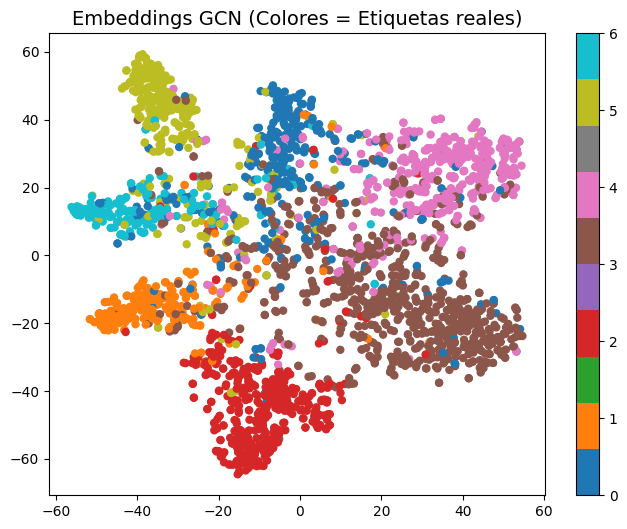

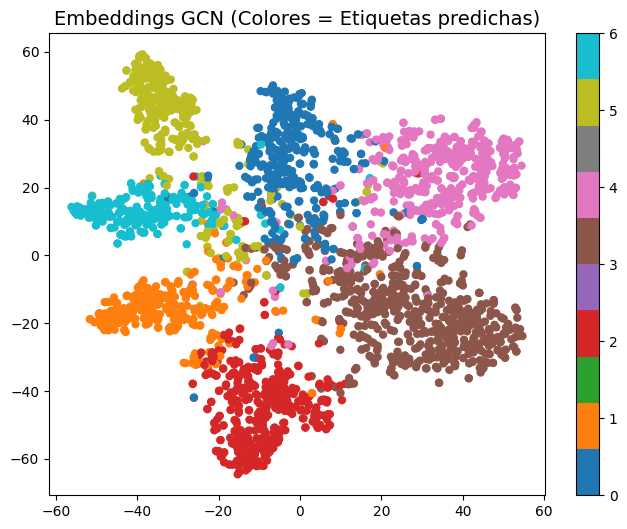

In [14]:
# Extraer las representaciones del hidden layer
model.eval()
with torch.no_grad():
    z = model.conv1(data.x, data.edge_index)
    z = z.cpu().numpy()

# Reducir a 2 dimensiones
z_2d = TSNE(n_components=2, learning_rate='auto').fit_transform(z)

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1).cpu().numpy()
y_true = data.y.cpu().numpy()


plt.figure(figsize=(8,6))
plt.scatter(z_2d[:,0], z_2d[:,1], c=y_true, cmap="tab10", s=25)
plt.title("Embeddings GCN (Colores = Etiquetas reales)", fontsize=14)
plt.colorbar()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:,0], z_2d[:,1], c=pred, cmap="tab10", s=25)
plt.title("Embeddings GCN (Colores = Etiquetas predichas)", fontsize=14)
plt.colorbar()
plt.show()

In [16]:

# VisualizacionD 3d con plotly
import plotly.graph_objs as go
from sklearn.manifold import TSNE

# Reducir a 3D
z_3d = TSNE(n_components=3, learning_rate='auto').fit_transform(z)

# plotly 3D
fig = go.Figure(data=[go.Scatter3d(
    x=z_3d[:, 0],
    y=z_3d[:, 1],
    z=z_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=data.y,        # colores según clase
        colorscale = 'Rainbow',
        opacity=0.85,
        colorbar=dict(title='Clase')
    ),
    text=[f"Node {i}, Label {data.y[i]}" for i in range(len(data.y))],
    hoverinfo='text'
)])

fig.update_layout(
    title="Embeddings 3D de nodos aprendidos por el GCN con etiquetas reales",
    scene=dict(
        xaxis_title="Dim 1",
        yaxis_title="Dim 2",
        zaxis_title="Dim 3",
    ),
    width=800,
    height=600
)

fig.show()
